In [ ]:
%pylab inline

In [ ]:
import torch
from torch import nn
import os
import numpy as np
import gc

from tqdm import tqdm

from torchvision import datasets, transforms
import torchvision.models as models
from torchsummary import summary

In [ ]:
!bash get-data.sh
!python3 split-cats.py

In [ ]:
class OneClassModel(torch.nn.Module):

    def __init__(self, feature_extractor, classifier):
        super(OneClassModel, self).__init__()
        self.features = feature_extractor
        self.classifier = classifier
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

    def forward_features(self, x):
        x = self.features(x)
        return x
    
    def forward_classifier(self, x):
        x = self.classifier(x)
        return x

    def probabilities(self, x):
        logits = self(x)
        return self.softmax(logits)

    def predict(self, x):
        logits = self(x)
        return torch.argmax(self.softmax(logits), axis = 1)

In [ ]:
image_net_transforms = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ]
    )

In [ ]:
def compute_error_rate(model, data_loader, cuda=True):
    model.eval()
    num_errs = 0.0
    num_examples = 0
    for x, y in data_loader:
        if cuda:
            x = x.cuda()
            y = y.cuda()

        with torch.no_grad():
            outputs = model.forward(x)
            _, predictions = outputs.max(dim=1)
            num_errs += (predictions != y).sum().item()
            num_examples += x.size(0)
    return 100.0 * num_errs / num_examples


def train(
    model, 
    data_loaders, 
    optimizer, 
    criterion, 
    num_epochs=1, 
    log_every=100, 
    cuda=True,
    verbose=True):

    if cuda:
        model.cuda()

    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}

    if verbose:
        print("Training the model!")
        print("You can interrupt it at any time.")
    try:
        while epoch < num_epochs:
            model.train()
            gc.collect()
            epoch += 1

            for x, y in data_loaders["train"]:

                if cuda:
                    x = x.cuda()
                    y = y.cuda()

                iter_ += 1
                optimizer.zero_grad()

                ## One class Training
                out_features = model.forward_features(x)
                noise = torch.randn_like(out_features, device='cuda')

                x_with_corrupted_data = torch.cat((out_features, noise), 0)
                

                labels_for_corrupted_data = torch.ones_like(y, device='cuda')
                y_with_corrupted_data = torch.cat((y, labels_for_corrupted_data), 0)

                out = model.forward_classifier(x_with_corrupted_data)

                ###
                loss = criterion(out, y_with_corrupted_data)
                loss.backward()
                optimizer.step()
                _, predictions = out.max(dim=1)
                err_rate = 100.0 * (predictions != y_with_corrupted_data).sum() / y_with_corrupted_data.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(err_rate.item())

                                
                if iter_ % log_every == 0 and verbose:
                    print(
                        "Minibatch {0: >6}  | loss {1: >1.5f}".format(
                            iter_, loss.item()
                        )
                    )

            val_err_rate = compute_error_rate(model, data_loaders["test"], cuda)
            history["val_errs"].append((iter_, val_err_rate))

            if val_err_rate < best_val_err:
        
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for p in model.parameters()]
                
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
                epoch, val_err_rate, num_epochs
            )
            if verbose:
                print("{0}\n{1}\n{0}".format("-" * len(m), m))

    except KeyboardInterrupt:
        pass
    if best_params is not None and verbose:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param
    if verbose:
       plot_history(history)

def plot_history(history):
    figsize(16, 4)
    subplot(1, 2, 1)
    train_loss = np.array(history["train_losses"])
    semilogy(np.arange(train_loss.shape[0]), train_loss, label="batch train loss")
    legend()

    subplot(1, 2, 2)
    train_errs = np.array(history["train_errs"])
    plot(np.arange(train_errs.shape[0]), train_errs, label="batch train error rate")
    val_errs = np.array(history["val_errs"])
    plot(val_errs[:, 0], val_errs[:, 1], label="validation error rate", color="r")
    ylim(0, 20)
    legend()

In [ ]:
path_to_dataset = '/content'
batch_size = 64

train_dataset = datasets.ImageFolder(os.path.join(path_to_dataset , 'Train'), 
                                     transform=image_net_transforms)

val_dataset = datasets.ImageFolder(os.path.join(path_to_dataset , 'Val'), 
                                     transform=image_net_transforms)

test_dataset = datasets.ImageFolder(os.path.join(path_to_dataset , 'Test'), 
                                    transform=image_net_transforms)

train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=32, 
                                               shuffle=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                               batch_size=32, 
                                               shuffle=True)


test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=32, 
                                              shuffle=True)

train_data_loaders = {"train": train_dataloader, 
                      "test": test_dataloader}

# vgg16

In [ ]:
vgg = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
features = nn.Sequential(vgg.features, nn.Flatten(), vgg.classifier[0])
classifier = nn.Sequential(nn.ReLU(),
                           nn.Linear(4096,1024),
                           nn.ReLU(),
                           nn.Linear(1024,512),
                           nn.ReLU(),
                           nn.Linear(512,2))

model = OneClassModel(features,classifier)

for p in model.features.parameters():
    p.requires_grad = False


for p in model.classifier.parameters():
    p.requires_grad = True

criterion = (nn.CrossEntropyLoss()) 

optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.0001)

In [ ]:
summary(model.cuda(), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

Training the model!
You can interrupt it at any time.
Minibatch    100  | loss 0.00164
Minibatch    200  | loss 0.00002
Minibatch    300  | loss 0.00002
----------------------------------------------------------
After epoch  1 | valid err rate:  9.92% | doing  20 epochs
----------------------------------------------------------
Minibatch    400  | loss 0.00001
Minibatch    500  | loss 0.00001
Minibatch    600  | loss 0.00035
----------------------------------------------------------
After epoch  2 | valid err rate:  9.82% | doing  20 epochs
----------------------------------------------------------
Minibatch    700  | loss 0.00000
Minibatch    800  | loss 0.00000
Minibatch    900  | loss 0.00000
----------------------------------------------------------
After epoch  3 | valid err rate:  8.59% | doing  20 epochs
----------------------------------------------------------
Minibatch   1000  | loss 0.00001
Minibatch   1100  | loss 0.00000
Minibatch   1200  | loss 0.00001
Minibatch   1300  |

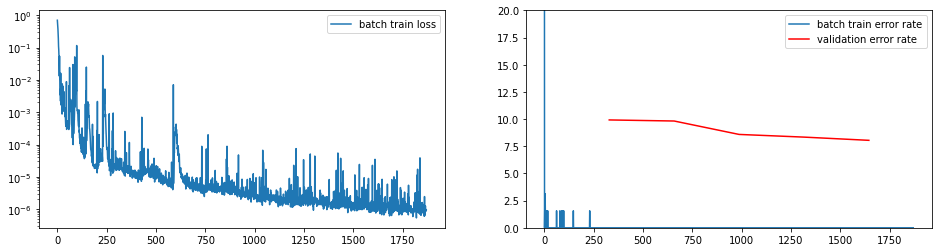

In [ ]:
train(
    model, 
    train_data_loaders, 
    optimizer, 
    criterion, 
    num_epochs=20, 
    log_every=100, 
    cuda=True,
    verbose=True)